In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
path ='DailyDelhiClimateTrain.csv'
data = pd.read_csv(path,index_col = 'date',parse_dates=['date'])

In [ ]:
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
data.shape

(1462, 4)

In [ ]:
data.dtypes

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [ ]:
data[['humidity']].describe()

,humidity
count,1462.000000
mean,60.771702
std,16.769652
min,13.428571
25%,50.375000
50%,62.625000
75%,72.218750
max,100.000000


In [ ]:
data.isnull().sum()/data.count()*100

meantemp        0.0
humidity        0.0
wind_speed      0.0
meanpressure    0.0
dtype: float64

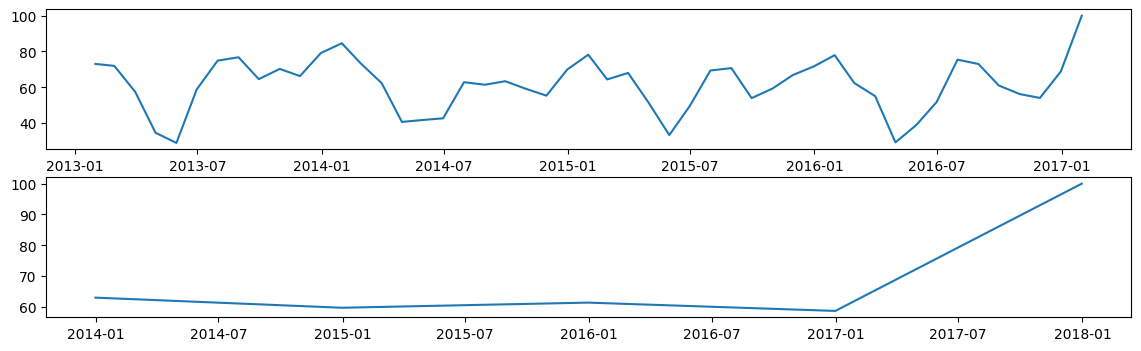

In [ ]:
plt.rcParams['figure.figsize'] = [14, 4]
annual_hum = data[['humidity']].resample('A').mean()
monthly_hum =data[['humidity']].resample('M').mean()
fig, axes = plt.subplots(2,1)
axes[0].plot(monthly_hum)
axes[1].plot(annual_hum)

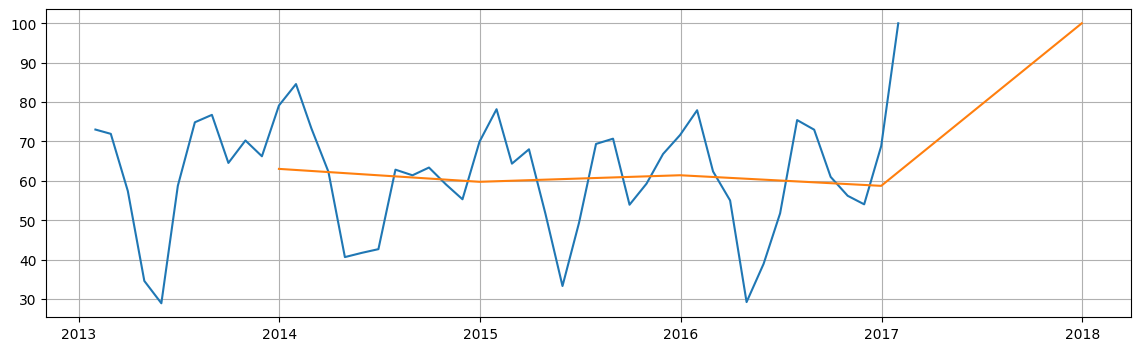

In [ ]:
plt.plot(monthly_hum)
plt.plot(annual_hum)
plt.grid();

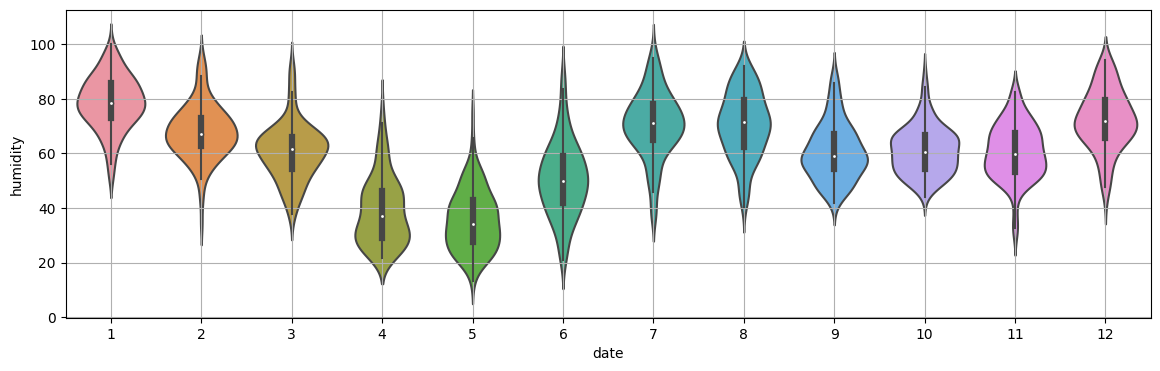

In [ ]:
sns.violinplot(x=data.index.month, y=data.humidity)
plt.grid();

In [ ]:
chunks = np.split(data.humidity, indices_or_sections=17)

In [ ]:
mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var
#mean_vals

,mean_vals,var_vals
0,67.584510,155.765468
1,39.760811,254.454181
2,70.881741,145.119857
3,69.550111,71.387891
4,79.157046,108.337503
5,46.703488,151.317990
6,55.188828,233.942932
7,59.748200,99.063556
8,70.870847,131.660193
9,56.999169,269.113698


In [ ]:
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

<Axes: >

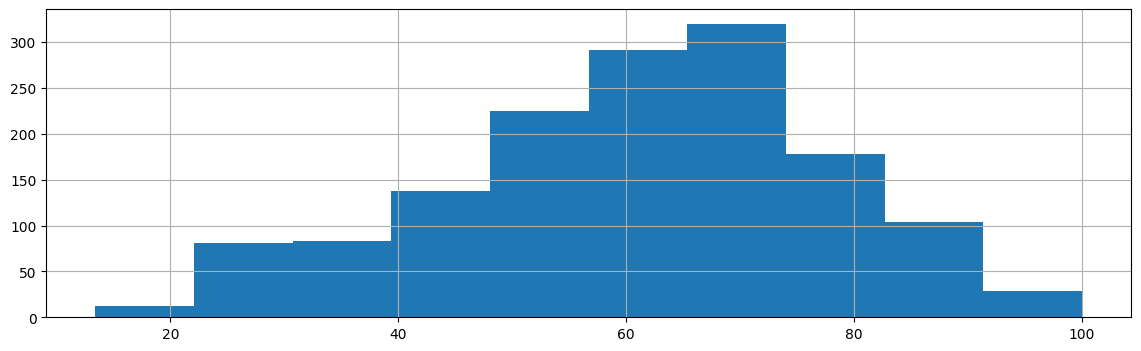

In [ ]:
data.humidity.hist()

In [ ]:
data['log_ss'] = np.log1p(data['humidity'])

<Axes: >

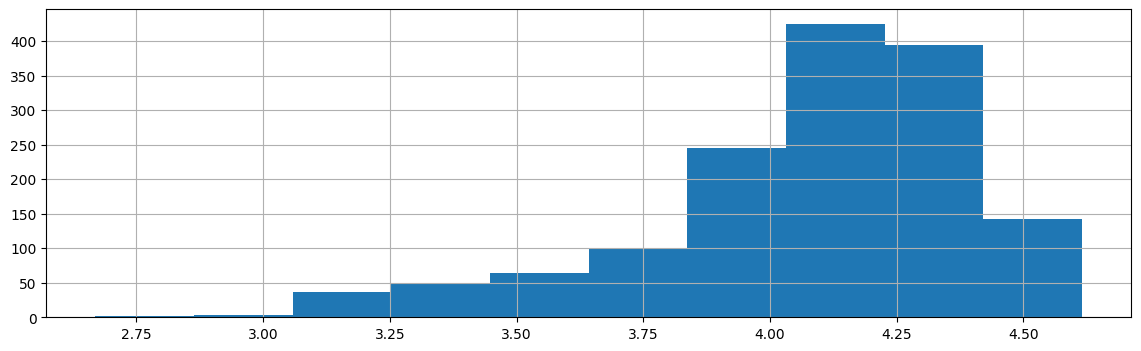

In [ ]:
data['log_ss'].hist()

Test Statistic            -3.675577
p-value                    0.004470
Lags Used                 15.000000
Observations Used       1446.000000
Critical Value (1%)       -3.434880
Critical Value (5%)       -2.863541
Critical Value (10%)      -2.567835
dtype: float64


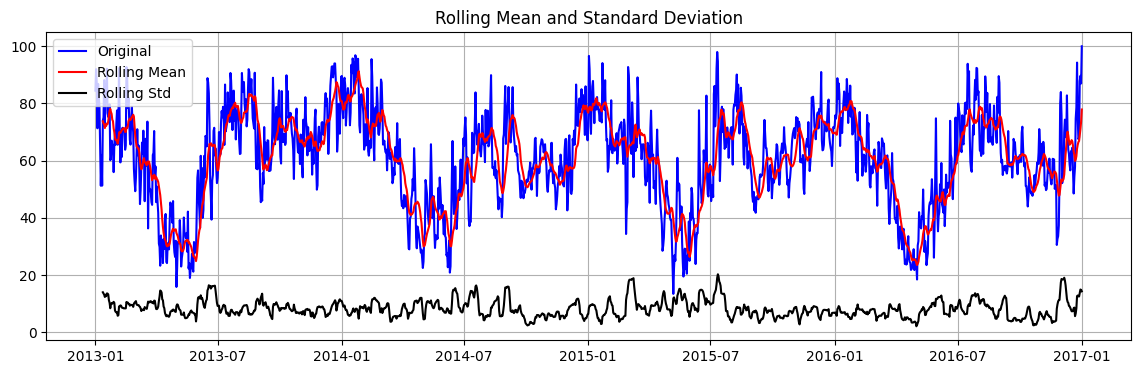

In [ ]:
dftest(data['humidity'].dropna())

Model Selection

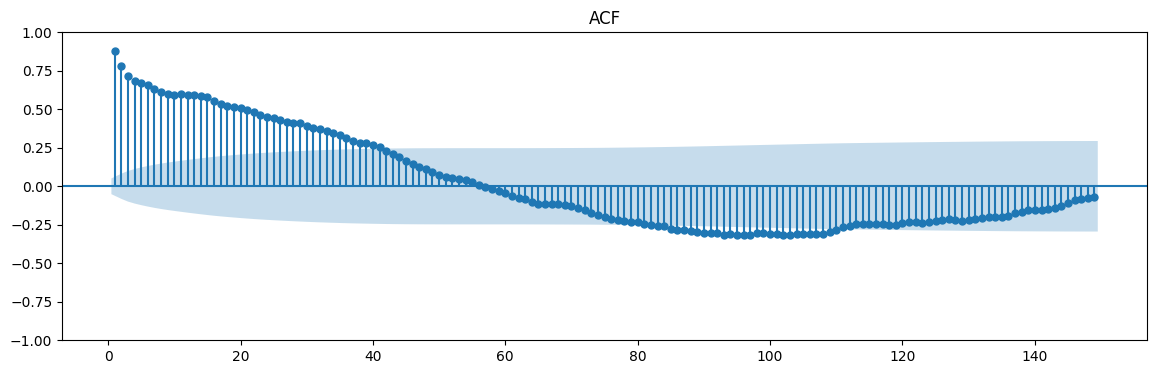

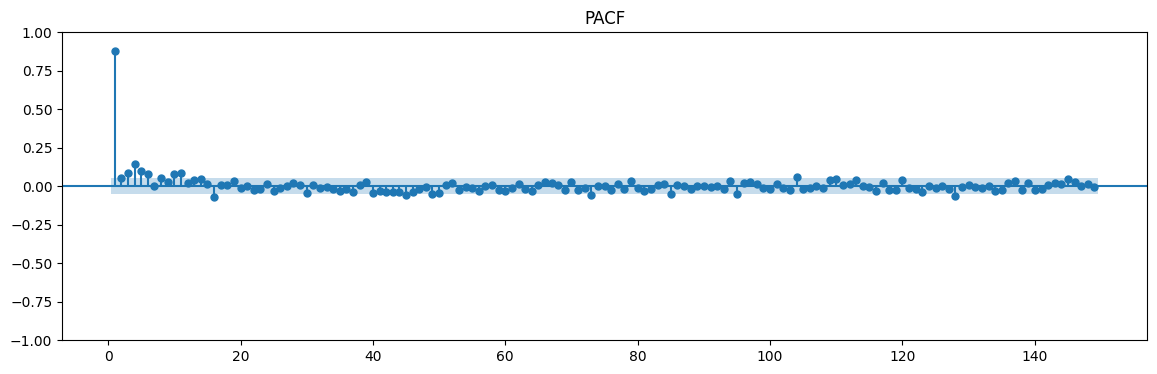

In [ ]:
fig = sm.tsa.graphics.plot_acf(data.humidity, lags=range(1,150), alpha=0.05, title = 'ACF')
fig = sm.tsa.graphics.plot_pacf(data.humidity, lags=range(1,150), alpha=0.05, title = 'PACF')

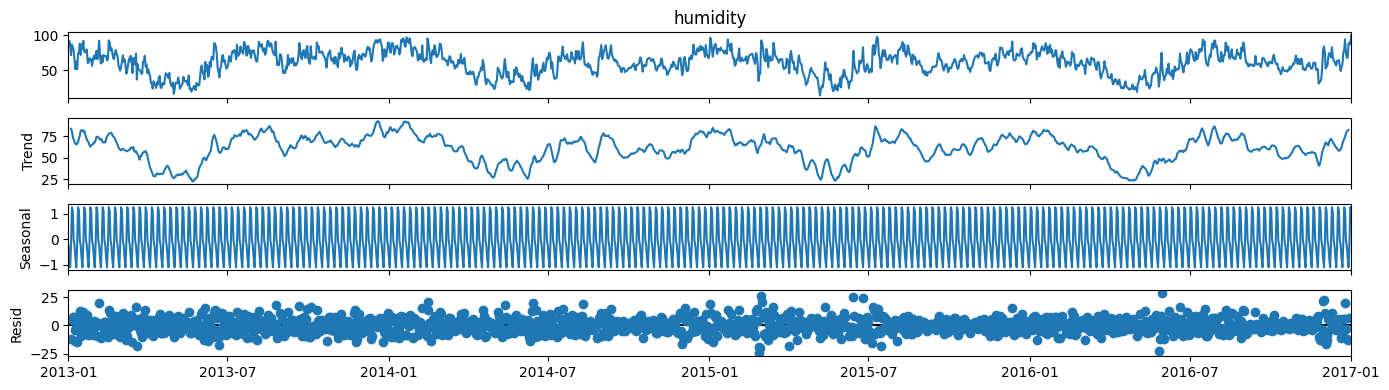

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(data.humidity,period = None).plot();

We are choosing SARIMA as there are seasonal trends in Humidity

In [ ]:
sar = sm.tsa.statespace.SARIMAX(data.humidity,
                                order=(2,0,0),
                                seasonal1_order=(0,0,2,12),
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               humidity   No. Observations:                 1462
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -5114.279
Date:                Sun, 13 Aug 2023   AIC                          10236.557
Time:                        14:28:22   BIC                          10257.707
Sample:                    01-01-2013   HQIC                         10244.446
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.9551      0.879      7.912      0.000       5.232       8.678
ar.L1          0.8331      0.025     33.359      0.000       0.784       0.882
ar.L2          0.0531      0.024      2.225      0.026       0.006       0.100
sigma2        63.9151      1.852     34.516      0.000      60.286      67.544
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               209.68
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

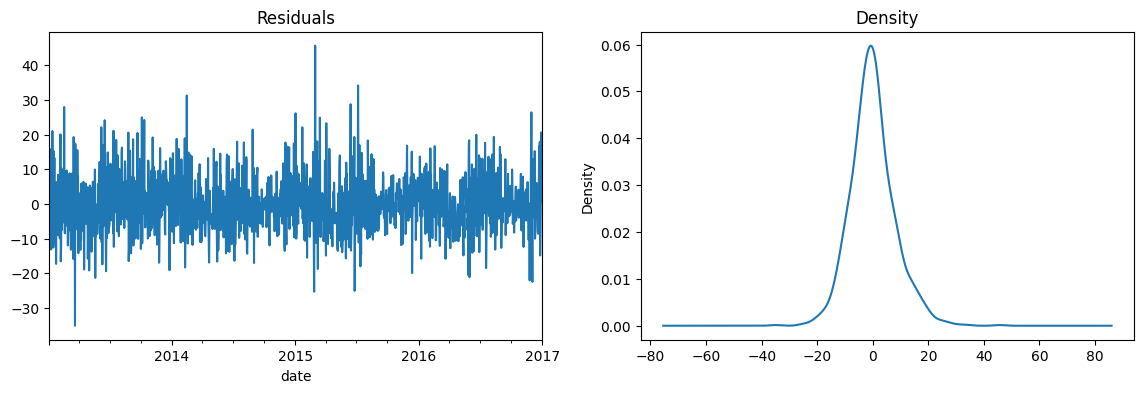

In [ ]:
residuals = sar.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

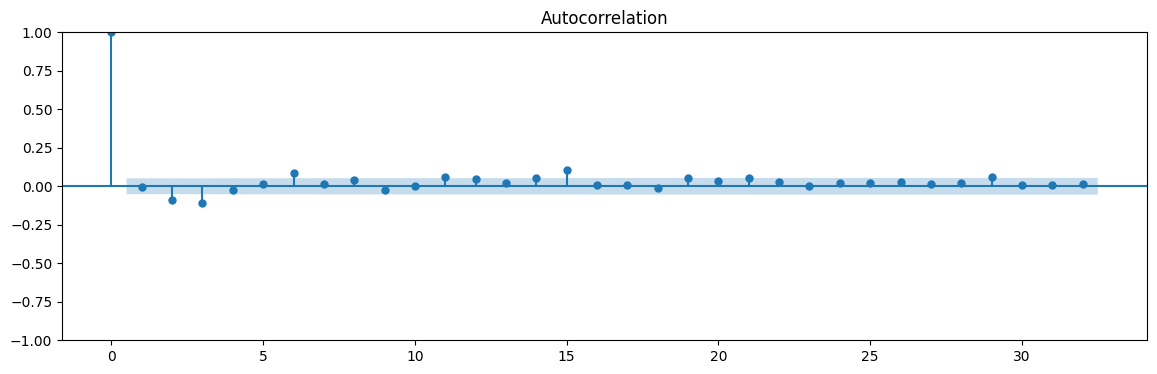

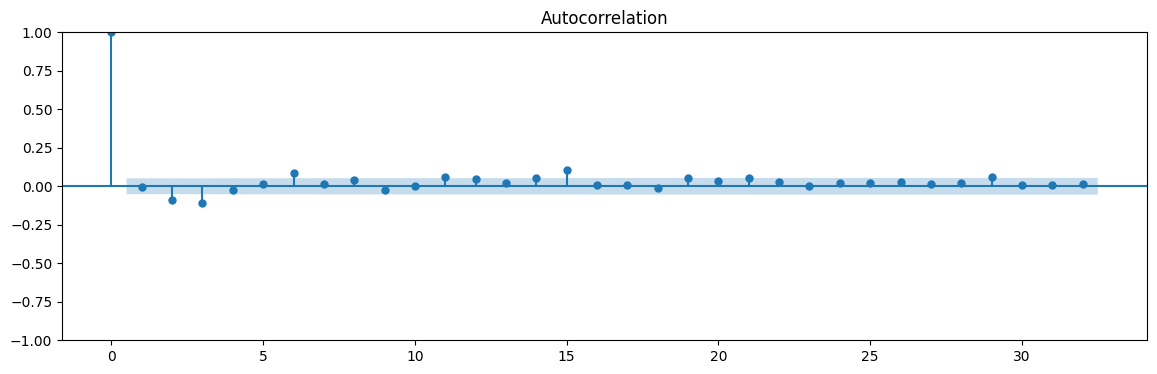

In [ ]:
acf_res = sm.tsa.graphics.plot_acf(residuals)

pacf_res = sm.tsa.graphics.plot_acf(residuals)


Prediction and Forecasting

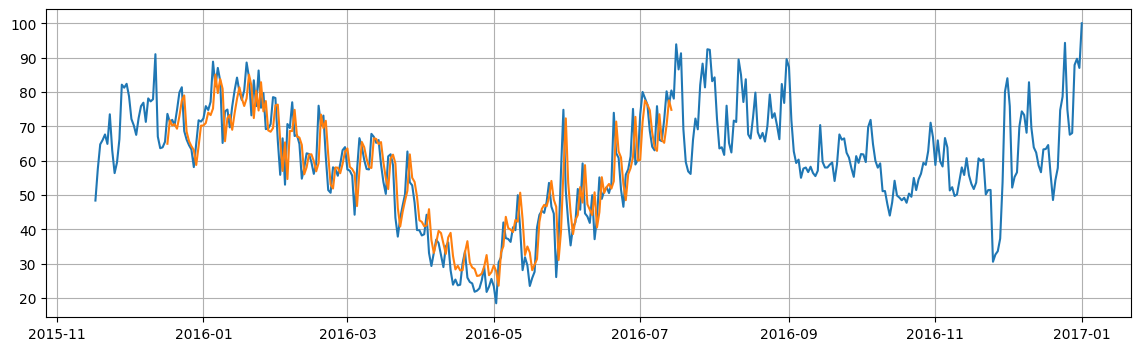

In [ ]:
data['forecast'] = sar.predict(start = 1080, end= 1290, dynamic=False)
plt.plot(data[1050:][['humidity', 'forecast']])
plt.grid();

Future Prediction

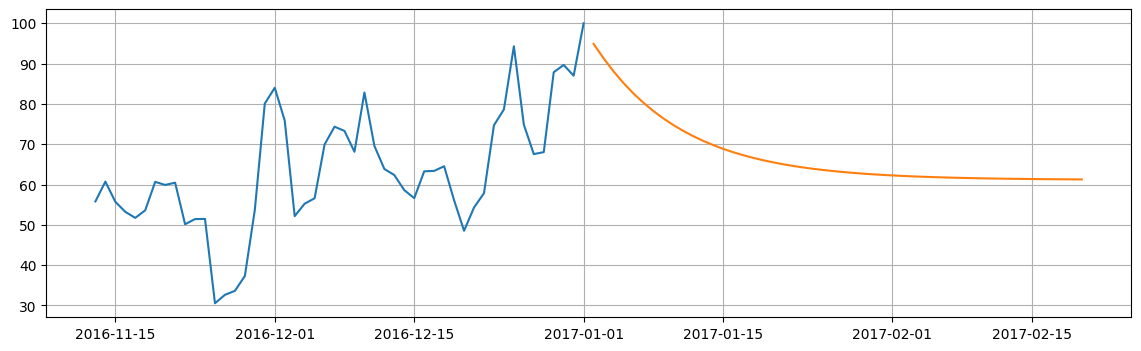

In [ ]:
future_fcst = sar.get_forecast(50)
# That will have a method to pull in confidence interval
confidence_int = future_fcst.conf_int(alpha = 0.01)
# Has an attribute to pull in predicted mean
fcst = future_fcst.predicted_mean
# Plot predictions and confidence intervals
plt.plot(data.humidity[-50:])
plt.plot(fcst)

plt.grid()